<a href="https://colab.research.google.com/github/dimitarpg13/rag_architectures_and_concepts/blob/main/src/examples/networkx/graphrag_demo/graphrag_networkx_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphRAG Toolkit: Complete Implementation Guide

This notebook demonstrates a comprehensive GraphRAG (Graph-based Retrieval Augmented Generation) workflow using modern tools and libraries. GraphRAG enhances traditional RAG by building knowledge graphs from documents, enabling more contextual and relationship-aware retrieval.

## Key Features Demonstrated:
- Document processing and chunking
- Knowledge graph construction
- Entity and relationship extraction
- Graph-based retrieval
- Context-aware generation
- Visualization and analysis tools

**Author**: GraphRAG Implementation Guide  
**Last Updated**: December 2024  
**Environment**: Google Colab Compatible

## 1. Installation and Setup

Install required packages for GraphRAG implementation.

In [9]:
# Core installations for GraphRAG
!pip install -q --upgrade pip
!pip install -q langchain langchain-community langchain-openai
!pip install -q networkx pyvis
!pip install -q sentence-transformers chromadb
!pip install -q spacy
!python -m spacy download en_core_web_sm
!pip install -q pandas numpy
!pip install -q python-dotenv
!pip install -q tiktoken
!pip install -q beautifulsoup4 requests
!pip install -q matplotlib seaborn

print("✅ All packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.3 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ All packages installed successfully!


In [1]:
# Import required libraries
import os
import json
import logging
from typing import List, Dict, Tuple, Optional, Any
from dataclasses import dataclass, field
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np

# NLP and ML
import spacy
from sentence_transformers import SentenceTransformer

# LangChain components
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Graph components
import networkx as nx
from pyvis.network import Network

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Configuration and API Setup

Configure API keys and model parameters. For Google Colab, we'll use environment variables or Colab secrets.

In [2]:
# Configuration class for GraphRAG
@dataclass
class GraphRAGConfig:
    """Configuration for GraphRAG pipeline"""

    # Model configuration
    llm_model: str = "gpt-4o-mini"
    embedding_model: str = "text-embedding-3-small"
    temperature: float = 0.7
    max_tokens: int = 2000

    # Chunking configuration
    chunk_size: int = 1000
    chunk_overlap: int = 200

    # Graph configuration
    max_entities_per_chunk: int = 10
    max_relationships_per_chunk: int = 15
    min_entity_confidence: float = 0.7

    # Retrieval configuration
    top_k_documents: int = 5
    top_k_graph_nodes: int = 10
    similarity_threshold: float = 0.7

    # Vector store configuration
    collection_name: str = "graphrag_demo"
    persist_directory: str = "./chroma_db"

# Initialize configuration
config = GraphRAGConfig()

# Setup API keys (use Colab secrets or environment variables)
def setup_api_keys():
    """Setup API keys from Colab secrets or manual input"""
    try:
        from google.colab import userdata
        os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
        print("✅ API key loaded from Colab secrets")
    except:
        # Manual input fallback
        import getpass
        api_key = getpass.getpass("Enter your OpenAI API key: ")
        os.environ["OPENAI_API_KEY"] = api_key
        print("✅ API key set manually")

setup_api_keys()

✅ API key loaded from Colab secrets


## 3. Core GraphRAG Components

Implementation of the core components for the GraphRAG pipeline.

In [3]:
@dataclass
class Entity:
    """Represents an entity in the knowledge graph"""
    name: str
    type: str
    description: str
    properties: Dict[str, Any] = field(default_factory=dict)
    confidence: float = 1.0
    source_chunks: List[str] = field(default_factory=list)

@dataclass
class Relationship:
    """Represents a relationship between entities"""
    source: str
    target: str
    type: str
    description: str
    properties: Dict[str, Any] = field(default_factory=dict)
    confidence: float = 1.0
    source_chunks: List[str] = field(default_factory=list)

class KnowledgeGraph:
    """Knowledge graph for storing entities and relationships"""

    def __init__(self):
        self.graph = nx.DiGraph()
        self.entities: Dict[str, Entity] = {}
        self.relationships: List[Relationship] = []

    def add_entity(self, entity: Entity):
        """Add an entity to the graph"""
        self.entities[entity.name] = entity
        self.graph.add_node(
            entity.name,
            type=entity.type,
            description=entity.description,
            properties=entity.properties,
            confidence=entity.confidence
        )

    def add_relationship(self, relationship: Relationship):
        """Add a relationship to the graph"""
        self.relationships.append(relationship)
        self.graph.add_edge(
            relationship.source,
            relationship.target,
            type=relationship.type,
            description=relationship.description,
            properties=relationship.properties,
            confidence=relationship.confidence
        )

    def get_subgraph(self, node: str, depth: int = 2) -> nx.DiGraph:
        """Get subgraph around a specific node"""
        nodes = nx.single_source_shortest_path_length(
            self.graph.to_undirected(), node, cutoff=depth
        ).keys()
        return self.graph.subgraph(nodes)

    def get_entity_context(self, entity_name: str) -> Dict:
        """Get context information for an entity"""
        if entity_name not in self.entities:
            return {}

        entity = self.entities[entity_name]
        neighbors = list(self.graph.neighbors(entity_name))
        predecessors = list(self.graph.predecessors(entity_name))

        return {
            "entity": entity,
            "neighbors": neighbors,
            "predecessors": predecessors,
            "degree": self.graph.degree(entity_name),
            "pagerank": nx.pagerank(self.graph).get(entity_name, 0)
        }

    def visualize(self, subset_nodes: Optional[List[str]] = None,
                  height: str = "600px", width: str = "100%"):
        """Visualize the knowledge graph"""
        net = Network(height=height, width=width, directed=True)

        # Select nodes to visualize
        if subset_nodes:
            subgraph = self.graph.subgraph(subset_nodes)
        else:
            subgraph = self.graph

        # Add nodes and edges
        for node, data in subgraph.nodes(data=True):
            net.add_node(
                node,
                label=f"{node}\n({data.get('type', 'Unknown')})",
                title=data.get('description', ''),
                color=self._get_node_color(data.get('type', 'Unknown'))
            )

        for source, target, data in subgraph.edges(data=True):
            net.add_edge(
                source, target,
                title=f"{data.get('type', 'relates_to')}: {data.get('description', '')}",
                label=data.get('type', 'relates_to')
            )

        # Generate HTML
        net.toggle_physics(True)
        net.show_buttons(filter_=['physics'])
        return net.generate_html()

    def _get_node_color(self, node_type: str) -> str:
        """Get color for node based on type"""
        color_map = {
            "Person": "#FF6B6B",
            "Organization": "#4ECDC4",
            "Location": "#45B7D1",
            "Event": "#96CEB4",
            "Concept": "#DDA0DD",
            "Product": "#F7DC6F",
            "Unknown": "#95A5A6"
        }
        return color_map.get(node_type, color_map["Unknown"])

print("✅ Core GraphRAG components defined!")

✅ Core GraphRAG components defined!


## 4. Entity and Relationship Extraction

Implement extraction of entities and relationships from text using LLMs.

In [4]:
class EntityRelationshipExtractor:
    """Extract entities and relationships from text using LLMs"""

    def __init__(self, config: GraphRAGConfig):
        self.config = config
        self.llm = ChatOpenAI(
            model=config.llm_model,
            temperature=config.temperature,
            max_tokens=config.max_tokens
        )
        self.nlp = spacy.load("en_core_web_sm")

    def extract_entities_relationships(self, text: str) -> Tuple[List[Entity], List[Relationship]]:
        """Extract entities and relationships from text"""

        # Define extraction prompt
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are an expert at extracting entities and relationships from text.
            Extract key entities (people, organizations, locations, concepts, events, products) and their relationships.

            Format your response as JSON with the following structure:
            {{
                "entities": [
                    {{
                        "name": "Entity Name",
                        "type": "Person|Organization|Location|Event|Concept|Product",
                        "description": "Brief description",
                        "confidence": 0.0-1.0
                    }}
                ],
                "relationships": [
                    {{
                        "source": "Source Entity Name",
                        "target": "Target Entity Name",
                        "type": "relationship_type",
                        "description": "Description of relationship",
                        "confidence": 0.0-1.0
                    }}
                ]
            }}

            Be comprehensive but accurate. Only extract entities and relationships that are clearly present in the text."""),
            ("user", "Extract entities and relationships from the following text:\n\n{text}")
        ])

        try:
            # Create chain and extract
            chain = extraction_prompt | self.llm | StrOutputParser()
            response = chain.invoke({"text": text})

            # Parse JSON response
            extracted_data = json.loads(response)

            # Create Entity objects
            entities = []
            for e in extracted_data.get("entities", []):
                if e.get("confidence", 0) >= self.config.min_entity_confidence:
                    entities.append(Entity(
                        name=e["name"],
                        type=e["type"],
                        description=e["description"],
                        confidence=e.get("confidence", 1.0),
                        source_chunks=[text[:100]]  # Store reference to source
                    ))

            # Create Relationship objects
            relationships = []
            entity_names = {e.name for e in entities}
            for r in extracted_data.get("relationships", []):
                # Only add relationships where both entities exist
                if r["source"] in entity_names and r["target"] in entity_names:
                    relationships.append(Relationship(
                        source=r["source"],
                        target=r["target"],
                        type=r["type"],
                        description=r["description"],
                        confidence=r.get("confidence", 1.0),
                        source_chunks=[text[:100]]
                    ))

            # Limit to configured maximums
            entities = entities[:self.config.max_entities_per_chunk]
            relationships = relationships[:self.config.max_relationships_per_chunk]

            return entities, relationships

        except Exception as e:
            logger.error(f"Error extracting entities/relationships: {e}")
            # Fallback to spaCy NER
            return self._fallback_extraction(text)

    def _fallback_extraction(self, text: str) -> Tuple[List[Entity], List[Relationship]]:
        """Fallback extraction using spaCy NER"""
        doc = self.nlp(text)
        entities = []

        for ent in doc.ents:
            entity_type_map = {
                "PERSON": "Person",
                "ORG": "Organization",
                "GPE": "Location",
                "LOC": "Location",
                "EVENT": "Event",
                "PRODUCT": "Product"
            }

            if ent.label_ in entity_type_map:
                entities.append(Entity(
                    name=ent.text,
                    type=entity_type_map[ent.label_],
                    description=f"{ent.label_} entity from text",
                    confidence=0.7,
                    source_chunks=[text[:100]]
                ))

        return entities[:self.config.max_entities_per_chunk], []

print("✅ Entity and Relationship Extractor defined!")

✅ Entity and Relationship Extractor defined!


## 5. GraphRAG Pipeline Implementation

Complete GraphRAG pipeline combining all components.

In [5]:
class GraphRAGPipeline:
    """Complete GraphRAG pipeline for document processing and retrieval"""

    def __init__(self, config: GraphRAGConfig):
        self.config = config
        self.knowledge_graph = KnowledgeGraph()
        self.extractor = EntityRelationshipExtractor(config)

        # Initialize embeddings and vector store
        self.embeddings = OpenAIEmbeddings(model=config.embedding_model)
        self.vector_store = None
        self.documents = []

        # Initialize text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=config.chunk_size,
            chunk_overlap=config.chunk_overlap,
            length_function=len,
            separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
        )

        # Initialize LLM for generation
        self.llm = ChatOpenAI(
            model=config.llm_model,
            temperature=config.temperature,
            max_tokens=config.max_tokens
        )

        # Metrics tracking
        self.metrics = {
            "total_documents": 0,
            "total_chunks": 0,
            "total_entities": 0,
            "total_relationships": 0,
            "processing_time": 0
        }

    def process_documents(self, texts: List[str], metadata: Optional[List[Dict]] = None):
        """Process documents to build knowledge graph and vector store"""
        start_time = datetime.now()

        logger.info(f"Processing {len(texts)} documents...")

        # Create documents with metadata
        if metadata is None:
            metadata = [{"source": f"doc_{i}"} for i in range(len(texts))]

        all_chunks = []

        for i, (text, meta) in enumerate(zip(texts, metadata)):
            # Split into chunks
            chunks = self.text_splitter.split_text(text)

            for j, chunk in enumerate(chunks):
                chunk_meta = {**meta, "chunk_id": f"{meta.get('source', f'doc_{i}')}_{j}"}
                all_chunks.append(Document(page_content=chunk, metadata=chunk_meta))

                # Extract entities and relationships from chunk
                entities, relationships = self.extractor.extract_entities_relationships(chunk)

                # Add to knowledge graph
                for entity in entities:
                    self.knowledge_graph.add_entity(entity)

                for relationship in relationships:
                    self.knowledge_graph.add_relationship(relationship)

                self.metrics["total_entities"] += len(entities)
                self.metrics["total_relationships"] += len(relationships)

            self.metrics["total_documents"] += 1
            logger.info(f"Processed document {i+1}/{len(texts)}")

        # Create vector store
        self.documents = all_chunks
        self.metrics["total_chunks"] = len(all_chunks)

        self.vector_store = Chroma.from_documents(
            documents=all_chunks,
            embedding=self.embeddings,
            collection_name=self.config.collection_name,
            persist_directory=self.config.persist_directory
        )

        self.metrics["processing_time"] = (datetime.now() - start_time).total_seconds()
        logger.info(f"Processing complete in {self.metrics['processing_time']:.2f} seconds")

        return self.metrics

    def retrieve(self, query: str) -> Dict:
        """Retrieve relevant context using both vector search and graph traversal"""

        # 1. Vector similarity search
        vector_results = self.vector_store.similarity_search_with_score(
            query, k=self.config.top_k_documents
        )

        # 2. Extract entities from query
        query_entities, _ = self.extractor.extract_entities_relationships(query)

        # 3. Graph-based retrieval
        graph_context = {}
        for entity in query_entities:
            if entity.name in self.knowledge_graph.entities:
                context = self.knowledge_graph.get_entity_context(entity.name)
                graph_context[entity.name] = context

        # 4. Find related entities through graph traversal
        related_entities = set()
        for entity_name in graph_context.keys():
            subgraph = self.knowledge_graph.get_subgraph(entity_name, depth=2)
            related_entities.update(subgraph.nodes())

        # 5. Combine results
        return {
            "vector_results": vector_results,
            "query_entities": query_entities,
            "graph_context": graph_context,
            "related_entities": list(related_entities)[:self.config.top_k_graph_nodes]
        }

    def generate_response(self, query: str, retrieval_results: Dict) -> str:
        """Generate response using retrieved context"""

        # Build context from vector results
        vector_context = "\n\n".join([
            f"[Score: {score:.3f}] {doc.page_content}"
            for doc, score in retrieval_results["vector_results"]
        ])

        # Build context from graph
        graph_context_str = ""
        for entity_name, context in retrieval_results["graph_context"].items():
            entity = context["entity"]
            graph_context_str += f"\n\nEntity: {entity_name} ({entity.type})\n"
            graph_context_str += f"Description: {entity.description}\n"
            graph_context_str += f"Connected to: {', '.join(context['neighbors'][:5])}\n"
            graph_context_str += f"PageRank Score: {context['pagerank']:.4f}"

        # Build prompt
        generation_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a helpful assistant that answers questions using provided context.
            Use both the document context and knowledge graph information to provide comprehensive answers.
            Cite specific entities and relationships when relevant.
            If the context doesn't contain enough information, say so."""),
            ("user", """Question: {query}

            Document Context:
            {vector_context}

            Knowledge Graph Context:
            {graph_context}

            Related Entities: {related_entities}

            Please provide a comprehensive answer based on the above context.""")
        ])

        # Generate response
        chain = generation_prompt | self.llm | StrOutputParser()
        response = chain.invoke({
            "query": query,
            "vector_context": vector_context,
            "graph_context": graph_context_str,
            "related_entities": ", ".join(retrieval_results["related_entities"][:10]),
        })

        return response

    def query(self, query: str) -> Dict:
        """End-to-end query processing"""
        logger.info(f"Processing query: {query}")

        # Retrieve context
        retrieval_results = self.retrieve(query)

        # Generate response
        response = self.generate_response(query, retrieval_results)

        return {
            "query": query,
            "response": response,
            "retrieval_results": retrieval_results,
            "metrics": self.get_query_metrics(retrieval_results)
        }

    def get_query_metrics(self, retrieval_results: Dict) -> Dict:
        """Calculate query metrics"""
        return {
            "num_documents_retrieved": len(retrieval_results["vector_results"]),
            "num_entities_found": len(retrieval_results["query_entities"]),
            "num_graph_contexts": len(retrieval_results["graph_context"]),
            "num_related_entities": len(retrieval_results["related_entities"]),
            "avg_similarity_score": np.mean([
                score for _, score in retrieval_results["vector_results"]
            ]) if retrieval_results["vector_results"] else 0
        }

    def visualize_graph(self, max_nodes: int = 50):
        """Visualize the knowledge graph"""
        # Get top nodes by PageRank
        if len(self.knowledge_graph.graph.nodes()) > max_nodes:
            pagerank = nx.pagerank(self.knowledge_graph.graph)
            top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
            subset_nodes = [node for node, _ in top_nodes]
        else:
            subset_nodes = None

        return self.knowledge_graph.visualize(subset_nodes=subset_nodes)

    def get_statistics(self) -> pd.DataFrame:
        """Get detailed statistics about the knowledge graph"""
        stats = {
            "Metric": [
                "Total Documents",
                "Total Chunks",
                "Total Entities",
                "Total Relationships",
                "Graph Nodes",
                "Graph Edges",
                "Average Node Degree",
                "Graph Density",
                "Number of Components",
                "Processing Time (seconds)"
            ],
            "Value": [
                self.metrics["total_documents"],
                self.metrics["total_chunks"],
                self.metrics["total_entities"],
                self.metrics["total_relationships"],
                self.knowledge_graph.graph.number_of_nodes(),
                self.knowledge_graph.graph.number_of_edges(),
                np.mean(list(dict(self.knowledge_graph.graph.degree()).values()))
                    if self.knowledge_graph.graph.number_of_nodes() > 0 else 0,
                nx.density(self.knowledge_graph.graph)
                    if self.knowledge_graph.graph.number_of_nodes() > 0 else 0,
                nx.number_weakly_connected_components(self.knowledge_graph.graph)
                    if self.knowledge_graph.graph.number_of_nodes() > 0 else 0,
                self.metrics["processing_time"]
            ]
        }
        return pd.DataFrame(stats)

print("✅ GraphRAG Pipeline implemented!")

✅ GraphRAG Pipeline implemented!


## 6. Example Usage with Sample Data

Demonstrate the GraphRAG pipeline with sample documents.

In [6]:
# Sample documents for demonstration
sample_documents = [
    """Apple Inc. is an American multinational technology company headquartered in Cupertino, California.
    Tim Cook has been the CEO of Apple since 2011, succeeding Steve Jobs. Apple designs, develops, and sells
    consumer electronics, computer software, and online services. The company's hardware products include
    the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the Apple Watch smartwatch,
    and the Apple TV digital media player. Apple's software includes the macOS and iOS operating systems,
    the iTunes media player, and the Safari web browser. The company was founded by Steve Jobs, Steve Wozniak,
    and Ronald Wayne in April 1976. Apple became the first publicly traded U.S. company to be valued at over
    $1 trillion in 2018.""",

    """Microsoft Corporation is an American multinational technology company with headquarters in Redmond, Washington.
    Satya Nadella has been the CEO since 2014, succeeding Steve Ballmer. Microsoft develops, manufactures, licenses,
    supports, and sells computer software, consumer electronics, personal computers, and related services. Its best
    known software products are the Microsoft Windows line of operating systems, the Microsoft Office suite, and
    the Internet Explorer and Edge web browsers. Microsoft was founded by Bill Gates and Paul Allen on April 4, 1975.
    The company has made numerous acquisitions, including LinkedIn for $26.2 billion in 2016 and GitHub for
    $7.5 billion in 2018. Microsoft's Azure cloud platform competes directly with Amazon Web Services.""",

    """Google, officially known as Alphabet Inc. since 2015, is an American multinational conglomerate headquartered
    in Mountain View, California. Sundar Pichai serves as CEO of both Google and Alphabet. The company was originally
    founded by Larry Page and Sergey Brin while they were Ph.D. students at Stanford University in 1998. Google's
    rapid growth since incorporation has triggered a chain of products, acquisitions, and partnerships beyond Google's
    core search engine. The company offers services designed for work and productivity (Google Docs, Google Sheets,
    and Google Slides), email (Gmail), scheduling and time management (Google Calendar), cloud storage (Google Drive),
    instant messaging and video chat (Google Duo, Google Chat, and Google Meet), language translation (Google Translate),
    mapping and navigation (Google Maps, Waze, Google Earth, and Street View), and video sharing (YouTube).""",

    """Amazon.com, Inc. is an American multinational technology company based in Seattle, Washington, which focuses on
    e-commerce, cloud computing, digital streaming, and artificial intelligence. Andy Jassy became CEO in 2021,
    succeeding founder Jeff Bezos. Amazon is one of the Big Five companies in the U.S. information technology industry,
    along with Google, Apple, Microsoft, and Facebook. The company has been referred to as one of the most influential
    economic and cultural forces in the world. Amazon was founded by Jeff Bezos in 1994 as an online marketplace for books
    but later expanded to sell electronics, software, video games, apparel, furniture, food, toys, and jewelry.
    Amazon Web Services (AWS) provides on-demand cloud computing platforms and APIs to individuals, companies, and governments."""
]

# Metadata for documents
sample_metadata = [
    {"source": "apple_overview", "company": "Apple", "date": "2024-12"},
    {"source": "microsoft_overview", "company": "Microsoft", "date": "2024-12"},
    {"source": "google_overview", "company": "Google", "date": "2024-12"},
    {"source": "amazon_overview", "company": "Amazon", "date": "2024-12"}
]

print(f"✅ Loaded {len(sample_documents)} sample documents")

✅ Loaded 4 sample documents


In [7]:
# Initialize GraphRAG pipeline
print("Initializing GraphRAG pipeline...")
graphrag = GraphRAGPipeline(config)

# Process documents
print("\nProcessing documents...")
metrics = graphrag.process_documents(sample_documents, sample_metadata)

# Display processing metrics
print("\n📊 Processing Metrics:")
display(graphrag.get_statistics())

Initializing GraphRAG pipeline...

Processing documents...

📊 Processing Metrics:


,Metric,Value
0,Total Documents,4.000000
1,Total Chunks,4.000000
2,Total Entities,40.000000
3,Total Relationships,44.000000
4,Graph Nodes,50.000000
5,Graph Edges,44.000000
6,Average Node Degree,1.760000
7,Graph Density,0.017959
8,Number of Components,8.000000
9,Processing Time (seconds),106.308203


## 7. Interactive Knowledge Graph Visualization

Visualize the constructed knowledge graph.

In [8]:
# Generate interactive graph visualization
import html as _html_mod

print("Generating knowledge graph visualization...")
graph_html = graphrag.visualize_graph(max_nodes=30)

# pyvis generate_html() returns a full HTML document. Embed it via an
# <iframe srcdoc="..."> so the visualization works everywhere — Google
# Colab, local Jupyter, and VS Code notebooks.
_escaped = _html_mod.escape(graph_html, quote=True)

display(HTML(f"""
<div style="border: 2px solid #ddd; padding: 10px; border-radius: 5px;">
    <h3>Knowledge Graph Visualization</h3>
    <p>Interactive graph showing entities and relationships extracted from documents.</p>
    <p><em>Note: Showing top 30 nodes by PageRank score. Use mouse to drag nodes and zoom.</em></p>
    <iframe srcdoc="{_escaped}" width="100%" height="620"
            style="border:none; margin-top:8px;" sandbox="allow-scripts"></iframe>
</div>
"""))

Generating knowledge graph visualization...


## 8. Query Examples and Response Generation

Demonstrate querying the GraphRAG system with various questions.

In [9]:
# Example queries
test_queries = [
    "Who are the current CEOs of major tech companies?",
    "What products does Apple make?",
    "Tell me about the founders of these tech companies.",
    "Which companies compete in cloud computing?",
    "What acquisitions have these companies made?"
]

# Process each query
for i, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"Query {i}: {query}")
    print(f"{'='*80}")

    # Execute query
    result = graphrag.query(query)

    # Display response
    print(f"\n📝 Response:\n{result['response']}")

    # Display metrics
    print(f"\n📊 Query Metrics:")
    for metric, value in result['metrics'].items():
        print(f"  • {metric}: {value}")

    # Display found entities
    if result['retrieval_results']['query_entities']:
        print(f"\n🔍 Entities found in query:")
        for entity in result['retrieval_results']['query_entities']:
            print(f"  • {entity.name} ({entity.type}): {entity.description}")

    # Display related entities from graph
    if result['retrieval_results']['related_entities']:
        print(f"\n🕸️ Related entities from graph:")
        print(f"  {', '.join(result['retrieval_results']['related_entities'][:10])}")


Query 1: Who are the current CEOs of major tech companies?

📝 Response:
Based on the provided context, here are the current CEOs of two major tech companies:

1. **Apple Inc.** - Tim Cook has been the CEO since 2011, succeeding Steve Jobs. Apple is known for its consumer electronics such as the iPhone, iPad, and Mac, as well as software like macOS and iOS.

2. **Microsoft Corporation** - Satya Nadella has served as the CEO since 2014, succeeding Steve Ballmer. Microsoft is recognized for its software products, including the Windows operating system and Microsoft Office suite.

If you need information on other major tech companies and their CEOs, please specify, as the current context only includes Apple and Microsoft.

📊 Query Metrics:
  • num_documents_retrieved: 5
  • num_entities_found: 2
  • num_graph_contexts: 0
  • num_related_entities: 0
  • avg_similarity_score: 1.0218346834182739

🔍 Entities found in query:
  • tech companies (Concept): General term for companies that special

## 9. Advanced Analysis and Insights

Perform advanced analysis on the knowledge graph.

In [10]:
# Graph analysis
print("🔬 Advanced Graph Analysis\n")

# Calculate PageRank
if graphrag.knowledge_graph.graph.number_of_nodes() > 0:
    pagerank = nx.pagerank(graphrag.knowledge_graph.graph)
    top_entities = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

    print("Top 10 Entities by PageRank:")
    for i, (entity, score) in enumerate(top_entities, 1):
        entity_obj = graphrag.knowledge_graph.entities.get(entity)
        entity_type = entity_obj.type if entity_obj else "Unknown"
        print(f"{i:2}. {entity:30} ({entity_type:15}) - Score: {score:.4f}")

# Analyze connectivity
print("\n📊 Graph Connectivity Analysis:")
if graphrag.knowledge_graph.graph.number_of_nodes() > 0:
    # Degree centrality
    degree_centrality = nx.degree_centrality(graphrag.knowledge_graph.graph)
    avg_centrality = np.mean(list(degree_centrality.values()))

    # Clustering coefficient
    clustering = nx.average_clustering(graphrag.knowledge_graph.graph.to_undirected())

    print(f"  • Average Degree Centrality: {avg_centrality:.4f}")
    print(f"  • Average Clustering Coefficient: {clustering:.4f}")
    print(f"  • Number of Connected Components: {nx.number_weakly_connected_components(graphrag.knowledge_graph.graph)}")

    # Find most connected entities
    degrees = dict(graphrag.knowledge_graph.graph.degree())
    top_connected = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\n  Most Connected Entities:")
    for entity, degree in top_connected:
        print(f"    • {entity}: {degree} connections")

🔬 Advanced Graph Analysis

Top 10 Entities by PageRank:
 1. Apple Inc.                     (Organization   ) - Score: 0.0577
 2. Microsoft Corporation          (Organization   ) - Score: 0.0560
 3. California                     (Location       ) - Score: 0.0395
 4. Amazon.com, Inc.               (Organization   ) - Score: 0.0354
 5. Alphabet Inc.                  (Organization   ) - Score: 0.0314
 6. Google                         (Organization   ) - Score: 0.0298
 7. Amazon Web Services            (Unknown        ) - Score: 0.0288
 8. Mountain View                  (Location       ) - Score: 0.0258
 9. Satya Nadella                  (Person         ) - Score: 0.0243
10. Stanford University            (Organization   ) - Score: 0.0243

📊 Graph Connectivity Analysis:
  • Average Degree Centrality: 0.0359
  • Average Clustering Coefficient: 0.0420
  • Number of Connected Components: 8

  Most Connected Entities:
    • Apple Inc.: 15 connections
    • Microsoft Corporation: 12 connection

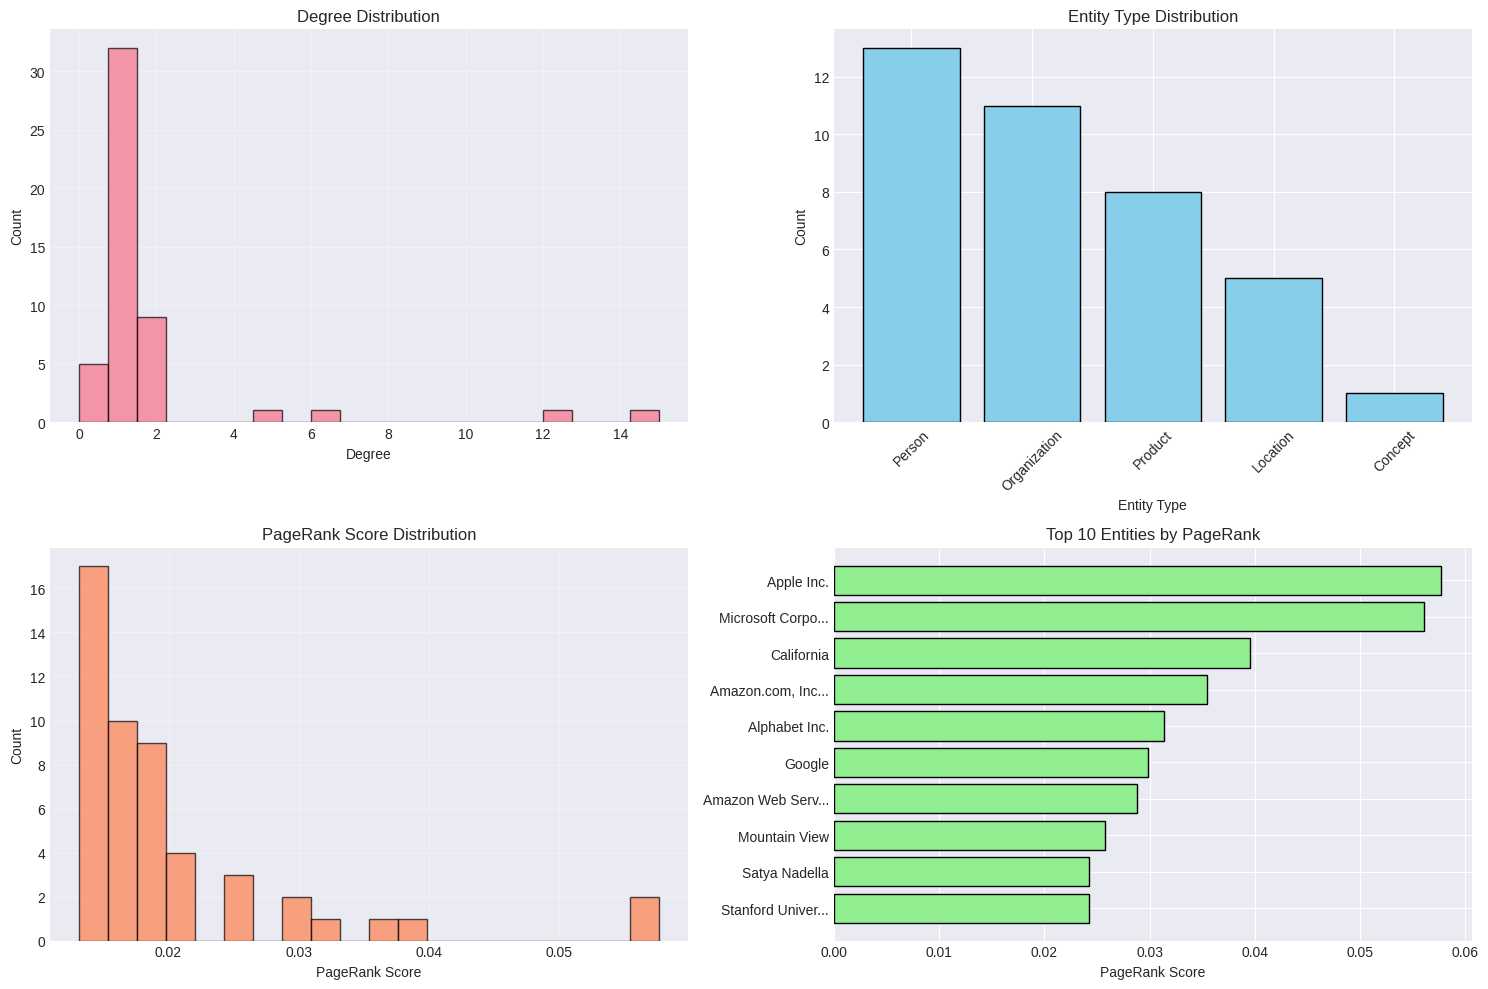


✅ Graph analysis visualizations complete!


In [11]:
# Visualize graph statistics
if graphrag.knowledge_graph.graph.number_of_nodes() > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Degree distribution
    degrees = [d for n, d in graphrag.knowledge_graph.graph.degree()]
    axes[0, 0].hist(degrees, bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Degree Distribution')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Entity type distribution
    entity_types = [e.type for e in graphrag.knowledge_graph.entities.values()]
    type_counts = pd.Series(entity_types).value_counts()
    axes[0, 1].bar(type_counts.index, type_counts.values, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Entity Type Distribution')
    axes[0, 1].set_xlabel('Entity Type')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. PageRank distribution
    pagerank_scores = list(pagerank.values())
    axes[1, 0].hist(pagerank_scores, bins=20, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 0].set_title('PageRank Score Distribution')
    axes[1, 0].set_xlabel('PageRank Score')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Top entities by PageRank
    top_10_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
    entities_pr = [e[0][:15] + '...' if len(e[0]) > 15 else e[0] for e in top_10_pagerank]
    scores_pr = [e[1] for e in top_10_pagerank]
    axes[1, 1].barh(entities_pr, scores_pr, color='lightgreen', edgecolor='black')
    axes[1, 1].set_title('Top 10 Entities by PageRank')
    axes[1, 1].set_xlabel('PageRank Score')
    axes[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    print("\n✅ Graph analysis visualizations complete!")
else:
    print("⚠️ No nodes in graph to analyze")

## 10. Export and Save Results

Export the knowledge graph and results for later use.

In [12]:
import pickle
from datetime import datetime

# Create export directory
export_dir = "/content/graphrag_export"
os.makedirs(export_dir, exist_ok=True)

# 1. Export knowledge graph
import pickle

graph_file = os.path.join(export_dir, "knowledge_graph.gpickle")
with open(graph_file, "wb") as f:
    pickle.dump(graphrag.knowledge_graph.graph, f, pickle.HIGHEST_PROTOCOL)
print(f"✅ Knowledge graph exported to {graph_file}")

# 2. Export entities and relationships as JSON
entities_data = {
    "entities": [
        {
            "name": e.name,
            "type": e.type,
            "description": e.description,
            "confidence": e.confidence
        } for e in graphrag.knowledge_graph.entities.values()
    ],
    "relationships": [
        {
            "source": r.source,
            "target": r.target,
            "type": r.type,
            "description": r.description,
            "confidence": r.confidence
        } for r in graphrag.knowledge_graph.relationships
    ]
}

json_file = os.path.join(export_dir, "entities_relationships.json")
with open(json_file, 'w') as f:
    json.dump(entities_data, f, indent=2)
print(f"✅ Entities and relationships exported to {json_file}")

# 3. Export metrics and statistics
stats_df = graphrag.get_statistics()
stats_file = os.path.join(export_dir, "graphrag_statistics.csv")
stats_df.to_csv(stats_file, index=False)
print(f"✅ Statistics exported to {stats_file}")

# 4. Save the entire pipeline (optional - for reloading later)
pipeline_file = os.path.join(export_dir, "graphrag_pipeline.pkl")
with open(pipeline_file, 'wb') as f:
    pickle.dump({
        "config": config,
        "metrics": graphrag.metrics,
        "timestamp": datetime.now().isoformat()
    }, f)
print(f"✅ Pipeline configuration saved to {pipeline_file}")

print(f"\n📦 All exports complete! Files saved to {export_dir}")

✅ Knowledge graph exported to /content/graphrag_export/knowledge_graph.gpickle
✅ Entities and relationships exported to /content/graphrag_export/entities_relationships.json
✅ Statistics exported to /content/graphrag_export/graphrag_statistics.csv
✅ Pipeline configuration saved to /content/graphrag_export/graphrag_pipeline.pkl

📦 All exports complete! Files saved to /content/graphrag_export


## 11. Advanced Querying with Custom Prompts

Demonstrate advanced querying capabilities with custom prompts.

In [13]:
def custom_query(graphrag_pipeline, query: str, custom_instructions: str = None):
    """Execute a query with custom instructions for response generation"""

    # Retrieve context
    retrieval_results = graphrag_pipeline.retrieve(query)

    # Build custom prompt
    if custom_instructions:
        system_prompt = f"""
        You are a helpful assistant that answers questions using provided context.
        {custom_instructions}
        """
    else:
        system_prompt = "You are a helpful assistant that answers questions using provided context."

    # Generate response with custom prompt
    vector_context = "\n\n".join([
        f"{doc.page_content}" for doc, _ in retrieval_results["vector_results"]
    ])

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", """Query: {query}

        Context: {context}

        Entities mentioned: {entities}

        Please provide your response based on the context.""")
    ])

    chain = prompt | graphrag_pipeline.llm | StrOutputParser()
    response = chain.invoke({
        "query": query,
        "context": vector_context,
        "entities": ", ".join(retrieval_results["related_entities"][:10]),
    })

    return response

# Example custom queries
print("🎯 Custom Query Examples\n")

# Query 1: Comparative analysis
print("Query 1: Comparative Analysis")
print("="*50)
response = custom_query(
    graphrag,
    "Compare the founding stories of Apple and Microsoft",
    "Provide a detailed comparison highlighting similarities and differences. Use bullet points for clarity."
)
print(response)

print("\n" + "="*80 + "\n")

# Query 2: Timeline extraction
print("Query 2: Timeline Extraction")
print("="*50)
response = custom_query(
    graphrag,
    "What are the key dates and milestones mentioned?",
    "Extract all dates and associated events. Format as a chronological timeline."
)
print(response)

print("\n" + "="*80 + "\n")

# Query 3: Relationship mapping
print("Query 3: Relationship Mapping")
print("="*50)
response = custom_query(
    graphrag,
    "What are the relationships between the CEOs and their companies?",
    "Focus on succession patterns and leadership transitions. Include dates where available."
)
print(response)

🎯 Custom Query Examples

Query 1: Comparative Analysis
Here is a detailed comparison of the founding stories of Apple and Microsoft, highlighting their similarities and differences:

### Similarities:
- **Founders**: Both companies were founded by notable individuals who played key roles in their early development:
  - Apple: Founded by Steve Jobs, Steve Wozniak, and Ronald Wayne.
  - Microsoft: Founded by Bill Gates and Paul Allen.
  
- **Founding Era**: Both companies were established in the mid-1970s during a time of rapid technological advancement:
  - Apple: Founded in April 1976.
  - Microsoft: Founded on April 4, 1975.

- **Growth into Giants**: Both companies have grown significantly since their founding and are now recognized as major players in the technology industry. They have both achieved monumental milestones in terms of market value and influence.

### Differences:
- **Headquarters**: 
  - Apple: Headquartered in Cupertino, California.
  - Microsoft: Headquartered in Re

## 12. Performance Optimization Tips

Best practices and optimization strategies for GraphRAG.

In [14]:
# Display optimization recommendations
optimization_tips = """
# GraphRAG Performance Optimization Guide

## 1. Document Processing Optimization
- **Batch Processing**: Process documents in batches of 10-20 for optimal memory usage
- **Chunk Size**: Adjust chunk_size (500-1500) based on document complexity
- **Overlap**: Use 10-20% overlap for better context preservation

## 2. Entity Extraction Optimization
- **Confidence Threshold**: Set min_entity_confidence to 0.7-0.8 to filter noise
- **Entity Limits**: Limit entities per chunk (10-15) to prevent graph explosion
- **Caching**: Cache entity extractions for repeated documents

## 3. Graph Structure Optimization
- **Pruning**: Remove nodes with degree < 2 for cleaner graphs
- **Merging**: Merge similar entities (using string similarity or embeddings)
- **Indexing**: Create indexes on frequently queried node properties

## 4. Retrieval Optimization
- **Hybrid Search**: Combine vector search with BM25 for better results
- **Graph Traversal Depth**: Limit to 2-3 hops for efficiency
- **Caching**: Cache frequent queries and their results

## 5. Scalability Considerations
- **Graph Database**: Use Neo4j or ArangoDB for graphs > 100K nodes
- **Vector Database**: Use Pinecone or Weaviate for production
- **Distributed Processing**: Use Ray or Dask for large document sets

## 6. Cost Optimization
- **Model Selection**: Use smaller models for entity extraction (gpt-3.5-turbo)
- **Batch API Calls**: Batch multiple chunks in single API calls
- **Local Models**: Consider using local models (Llama, Mistral) for extraction

## 7. Quality Improvements
- **Validation**: Implement entity/relationship validation logic
- **Feedback Loop**: Track query success and refine extraction prompts
- **Human-in-the-loop**: Add review step for critical entities
"""

display(Markdown(optimization_tips))

# Performance benchmarking function
def benchmark_graphrag(graphrag_pipeline, test_queries: List[str]):
    """Benchmark GraphRAG performance"""
    import time

    results = []
    for query in test_queries:
        start = time.time()
        result = graphrag_pipeline.query(query)
        end = time.time()

        results.append({
            "query": query[:50] + "...",
            "response_time": end - start,
            "entities_found": len(result['retrieval_results']['query_entities']),
            "docs_retrieved": len(result['retrieval_results']['vector_results']),
            "graph_nodes": len(result['retrieval_results']['related_entities'])
        })

    return pd.DataFrame(results)

# Run benchmark
print("\n📊 Performance Benchmark Results:")
benchmark_queries = [
    "Who founded Apple?",
    "What are Microsoft's main products?",
    "Compare cloud services offered by these companies"
]
benchmark_df = benchmark_graphrag(graphrag, benchmark_queries)
display(benchmark_df)


# GraphRAG Performance Optimization Guide

## 1. Document Processing Optimization
- **Batch Processing**: Process documents in batches of 10-20 for optimal memory usage
- **Chunk Size**: Adjust chunk_size (500-1500) based on document complexity
- **Overlap**: Use 10-20% overlap for better context preservation

## 2. Entity Extraction Optimization
- **Confidence Threshold**: Set min_entity_confidence to 0.7-0.8 to filter noise
- **Entity Limits**: Limit entities per chunk (10-15) to prevent graph explosion
- **Caching**: Cache entity extractions for repeated documents

## 3. Graph Structure Optimization
- **Pruning**: Remove nodes with degree < 2 for cleaner graphs
- **Merging**: Merge similar entities (using string similarity or embeddings)
- **Indexing**: Create indexes on frequently queried node properties

## 4. Retrieval Optimization
- **Hybrid Search**: Combine vector search with BM25 for better results
- **Graph Traversal Depth**: Limit to 2-3 hops for efficiency
- **Caching**: Cache frequent queries and their results

## 5. Scalability Considerations
- **Graph Database**: Use Neo4j or ArangoDB for graphs > 100K nodes
- **Vector Database**: Use Pinecone or Weaviate for production
- **Distributed Processing**: Use Ray or Dask for large document sets

## 6. Cost Optimization
- **Model Selection**: Use smaller models for entity extraction (gpt-3.5-turbo)
- **Batch API Calls**: Batch multiple chunks in single API calls
- **Local Models**: Consider using local models (Llama, Mistral) for extraction

## 7. Quality Improvements
- **Validation**: Implement entity/relationship validation logic
- **Feedback Loop**: Track query success and refine extraction prompts
- **Human-in-the-loop**: Add review step for critical entities



📊 Performance Benchmark Results:


,query,response_time,entities_found,docs_retrieved,graph_nodes
0,Who founded Apple?...,7.110553,1,5,1
1,What are Microsoft's main products?...,7.616148,2,5,1
2,Compare cloud services offered by these compan...,15.415977,2,5,0


## Conclusion

This notebook demonstrated a comprehensive GraphRAG implementation featuring:

### ✅ Key Capabilities Implemented:
- **Document Processing**: Chunking and metadata management
- **Entity & Relationship Extraction**: LLM-based extraction with fallback
- **Knowledge Graph Construction**: NetworkX-based graph with rich properties
- **Hybrid Retrieval**: Combining vector search and graph traversal
- **Context-Aware Generation**: Enhanced responses using graph context
- **Visualization**: Interactive graph visualization with Pyvis
- **Analysis Tools**: PageRank, centrality, and connectivity metrics
- **Export Capabilities**: Save graphs and results for reuse

### 🚀 Next Steps:
1. **Scale Up**: Process larger document collections
2. **Enhance Extraction**: Fine-tune prompts for your domain
3. **Production Deployment**: Migrate to graph databases (Neo4j)
4. **Advanced Features**: Add temporal reasoning, multi-hop queries
5. **Integration**: Connect with existing data pipelines

### 📚 Resources:
- [LangChain Documentation](https://python.langchain.com/)
- [NetworkX Documentation](https://networkx.org/)
- [OpenAI API Reference](https://platform.openai.com/docs/)
- [Graph Database Options](https://neo4j.com/)

This implementation provides a solid foundation for building production-ready GraphRAG systems that combine the power of knowledge graphs with modern retrieval-augmented generation techniques.